
# Twitter Sentiment Analysis using NLTK/pandas/sklearn

Dataset used for this notebook is the courtesy of Kaggle https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment
    
This data originally came from Crowdflower's Data for Everyone library.

As the original source says,
We looked through tens of thousands of tweets about the early August GOP debate in Ohio and asked contributors to do both 
sentiment analysis and data categorization. Contributors were asked if the tweet was relevant, which candidate was mentioned,
what subject was mentioned, and then what the sentiment was for a given tweet. 

In [27]:
#Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.ensemble import AdaBoostClassifier

In [15]:
#Get data
dataset=pd.read_csv('Sentiment.csv')
dataset.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [16]:
#Keep only necessary columns
dataset=dataset[['sentiment','text']]
dataset.head(5)

,sentiment,text
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...


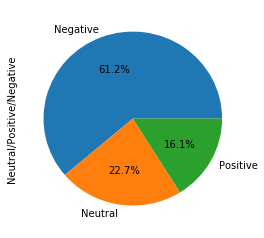

In [17]:
#Visualize using pie charts
dataset['sentiment'].value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(4,4))
plt.ylabel('Neutral/Positive/Negative')
plt.show()

In [18]:
#Drop Neutral values
dataset=dataset[dataset.sentiment!='Neutral']
#Encoding the msg catagory
dataset['sentiment']=dataset['sentiment'].map({'Negative':0,'Positive':1})


In [21]:
stemmer=SnowballStemmer('english')
def cleanText(message):
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")
                                                            and not word.startswith('@')
                                                            and not word.startswith('#')
                                                            and word!='RT'
                                                            and 'http' not in word]
    return " ".join(words)

dataset['text']=dataset['text'].apply(cleanText)
dataset.head(10)

,sentiment,text
1,1,scottwalk didnt catch full gopdeb last night s...
3,1,robgeorg car fiorina trend hour debat men just...
4,1,danscavino gopdeb w realdonaldtrump deliv high...
5,1,gregabbotttx tedcruz first day rescind everi i...
6,0,warriorwoman91 like happi heard go moder anymo...
8,0,deer headlight lizzwinstead ben carson may bra...
9,0,nancyosborne180 last night debat prove gopdeb ...
10,0,jgreendc realdonaldtrump fair billclinton own ...
11,1,waynedupreeshow woke tweet gopdeb best line ni...
12,0,read famili comment great gopdeb


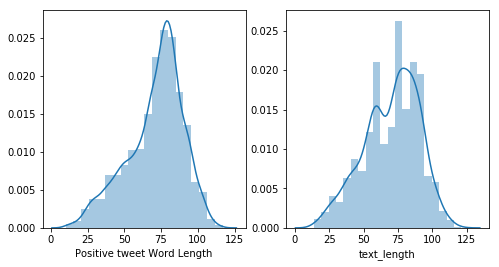

In [24]:
#Impact of length of messages to spam/ham
dataset['text_length']=dataset['text'].apply(len)

f, ax = plt.subplots(1, 2, figsize = (8, 4))

sns.distplot(dataset[dataset['sentiment'] == 0]['text_length'], bins = 20, ax = ax[0])
ax[0].set_xlabel('Negative tweet Word Length')

sns.distplot(dataset[dataset['sentiment'] == 1]['text_length'], bins = 20, ax = ax[1])
ax[0].set_xlabel('Positive tweet Word Length')

plt.show()


In [28]:
#Split dataset in independent and dependent variables
Y=dataset['sentiment'].values

#Calculate features for X
count_v = CountVectorizer(decode_error='ignore')
X=count_v.fit_transform(dataset['text'])

#Splitting the training and test data
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.15,stratify=Y)

In [32]:
#Creation/Training of the model
model_mnNB=MultinomialNB()
model_mnNB.fit(Xtrain,Ytrain)
ypred_mnNB=model_mnNB.predict(Xtest)

model_guNB=GaussianNB()
model_guNB.fit(Xtrain.toarray(),Ytrain)
ypred_guNB=model_guNB.predict(Xtest.toarray())

model_adab = AdaBoostClassifier(n_estimators=100)
model_adab.fit(Xtrain, Ytrain)
ypred_adab=model_adab.predict(Xtest)

In [35]:
#See the confusion Matrix for multinomial naive bayes
from sklearn.metrics import confusion_matrix
cm_mnNB=confusion_matrix(ypred_mnNB,Ytest)
print('confusion Matrix for multinomial naive bayes\n')
print(cm_mnNB)

#See the confusion Matrix for gaussian naive bayes
cm_guNB=confusion_matrix(ypred_guNB,Ytest)
print('\nconfusion Matrix for gaussian naive bayes')
print(cm_guNB)

#See the confusion Matrix for adaboost
cm_adab=confusion_matrix(ypred_adab,Ytest)
print('\nconfusion Matrix for adaboost')
print(cm_adab)

confusion Matrix for multinomial naive bayes

[[1120  127]
 [ 154  209]]

confusion Matrix for gaussian naive bayes
[[829  88]
 [445 248]]

confusion Matrix for adaboost
[[1195  176]
 [  79  160]]


In [37]:
#Score
print('\nScore for Multinomial NB')
print("train score:", model_mnNB.score(Xtrain, Ytrain))
print("test score:", model_mnNB.score(Xtest, Ytest))

print('\nScore for Gaussian NB')
print("train score:", model_guNB.score(Xtrain.toarray(), Ytrain))
print("test score:", model_guNB.score(Xtest.toarray(), Ytest))

print('\nScore for Adaboost')
print("train score:", model_adab.score(Xtrain, Ytrain))
print("test score:", model_adab.score(Xtest, Ytest))


Score for Multinomial NB
train score: 0.9115034543261322
test score: 0.8254658385093168

Score for Gaussian NB
train score: 0.8381401469459371
test score: 0.668944099378882

Score for Adaboost
train score: 0.8574405088277224
test score: 0.8416149068322981


# Multinomail NB is the best performer for this twitter sentiment analysis problem